In [1]:
from IPython.display import HTML

# Color Me Corrected: Error Correction with Color Codes on Neutral-Atom Hardware ⚛️🎨

## Learning Objectives

This lesson extends the ideas from the **circuit noise** tutorial to the regime of **logical qubits** and **fault-tolerant style circuits**. By the end of this notebook, you will be able to:

- Describe how a **simple two-qubit CX gate** fails in the presence of bit-flip noise
- Implement and simulate a **Steane $[[7,1,3]]$ logical CX** built from transversal gates
- Compare the performance of a **physical CX** and a **logical, error-corrected CX** under a controllable noise model
- Understand how **syndrome measurements** and **error-correction rounds** can suppress some errors, and why this is challenging in practice
- Relate your simulations to recent experiments on **logical processors based on color codes** with neutral atoms

Throughout the notebook, we will use `bloqade`, `squin`, and `pyqrack` to explore these ideas in a way that is directly inspired by state-of-the-art neutral-atom experiments.

---

## Quantum Error Correction Series

This notebook is the **first in a three-part series** exploring recent work by QuEra and collaborators on error correction using neutral-atom hardware:

1. **Color code and basic error correction**  ← *You are here* 📍
2. Magic State Distillation
3. Optimizing error-correction protocols: correlated decoding and flag qubits

---

## From Circuit Noise to Logical Processors 💻

In the previous tutorial, [Evaluating circuit-level performance under realistic noise](https://github.com/QuEraComputing/quera-education/blob/main/IEEE_2025/circuit_noise.ipynb), the focus was on understanding how different noise channels affect circuits on QuEra’s Gemini-class neutral-atom devices. In that notebook, we asked questions such as:

- How do global and local gates differ in their noise behavior?
- How can a circuit be structured to take advantage of lower-noise global layers?
- How do atom zoning and movement change the effective noise seen by a circuit?

Here, we take a step further up the abstraction ladder: **from physical qubits to logical qubits**.

Quantum error correction is the theoretical and experimental framework that allows us to encode fragile quantum information into **many physical qubits** in order to protect it from noise.

---

## Connection to Recent Experiments

The ideas explored in this notebook are directly connected to the **logical quantum processor** demonstrated by QuEra and collaborators in:

- Bluvstein *et al.*, *Logical quantum processor based on reconfigurable atom arrays* (Nature, 2024)
  https://www.nature.com/articles/s41586-023-06927-3

and to more recent work on logical state preparation and distillation:

- Rodriguez *et al.*, *Experimental demonstration of logical magic state distillation* (Nature, 2025)
  https://www.nature.com/articles/s41586-025-09367-3

In particular:

- **Figure 3 of Bluvstein *et al.*** shows **distance-3 color codes** coupled by **transversal CX gates** to implement logical GHZ states and error-detected algorithms.

<div align="center">
  <img src="./assets/bluvstein_figure_3a.png" width="1000">
</div>

- Similar distance-3 color codes appear in the more recent work on logical magic state preparation as building blocks for the distillation protocol.

<div align="center">
  <img src="./assets/rodriguez_figure_1b.png" width="1000">
</div>

---

## What is a Color Code? What is the Steane Code?

A **color code** is a type of quantum error-correcting code defined on a two-dimensional lattice whose faces can be colored (typically red, green, and blue) such that no two neighboring faces share the same color. By extracting parity information about the qubits on a face—without collapsing the individual physical qubits—we can detect and correct errors acting on the encoded state.

Here is the simplest color-code-like structure, which uses 7 physical qubits to encode 1 logical qubit, taken from the [Error Correction Zoo](https://errorcorrectionzoo.org/c/steane). This code is known as the **Steane code**.

<div align="center">
  <img src="./assets/steane_code.svg" width="300">
</div>

Each colored face of the Steane code corresponds to two stabilizers: one composed only of $X$ operators and one composed only of $Z$ operators. This special structure enables many logical **Clifford gates** to be performed *transversally* (gate-by-gate across corresponding physical qubits), which is a powerful property for fault-tolerant quantum computing.

Using the standard $[[n, k, d]]$ notation:

- $n$ = number of physical qubits
- $k$ = number of logical qubits
- $d$ = distance of the code

the **Steane code** is written as $[[7,1,3]]$. This means it encodes one logical qubit into **seven physical qubits** and can correct **any single-qubit error**. The distance parameter indicates that the smallest error chain that can change a logical state has length 3; in practice, this means the code can correct up to **one error**.

Because it supports **transversal Clifford operations** such as CX, Hadamard, and Phase gates, the $d = 3$ color-code family is a natural starting point for **near-term experiments in neutral-atom platforms**.

---

## Goals of This Notebook

Our goal here is **not** to reproduce large-scale experiments in full detail. Instead, we will:

- Build a **Steane-encoded logical CX gate** and a single (partial) **error-correction round** using SQUIN
- Use a **simple, tunable noise model** to study when encoding helps and when it does not
- Develop intuition for the **challenges and trade-offs** involved in practical quantum error correction

This notebook therefore serves as both:

- A **primer on quantum error correction**, and
- A bridge between theory and **current experimental work on neutral-atom logical qubits**

By the end, you should have a more realistic sense of both the **power** and the **limitations** of error correction in today’s machines.


In [2]:
from typing import Any, Tuple

import cirq
import numpy as np
from bloqade import squin
from bloqade.cirq_utils import load_circuit, emit_circuit
from bloqade.cirq_utils.noise import transform_circuit
from bloqade.pyqrack import StackMemorySimulator
from bloqade.types import Qubit, MeasurementResult
from kirin.dialects.ilist import IList
from utils import BitFlipOn2QGateNoiseModel, plot_qec_by_run, plot_qec_by_noise

Register = IList[Qubit, Any]

# 🔉 1. Baseline: a single noisy CX gate

We begin with the simplest possible test:

1. Allocate two qubits.
2. Prepare the state $|10\rangle$ by applying an $X$ to the first qubit.
3. Apply a single **CX gate**.
4. Measure both qubits in the computational basis.

In the **ideal** case, the output is always $|11\rangle$. This gives us a baseline circuit:

In [3]:
@squin.kernel
def cx_experiment() -> Tuple[MeasurementResult, MeasurementResult]:
    qubits = squin.qalloc(2)
    squin.x(qubits[0])

    squin.cx(qubits[0], qubits[1])

    result1 = squin.qubit.measure(qubits[0])
    result2 = squin.qubit.measure(qubits[1])

    return result1, result2

In [4]:
print(emit_circuit(mt=cx_experiment, ignore_returns=True))

0: ───X───@───M───
          │
1: ───────X───M───


In [5]:
emulator_2q = StackMemorySimulator(min_qubits=2)
cx_task = emulator_2q.task(kernel=cx_experiment)
cx_results = cx_task.batch_run(shots=1000)
print("CX experiment measurement result:", cx_results)

CX experiment measurement result: {(<Measurement.One: 1>, <Measurement.One: 1>): 1.0}


## 1.1 A controllable bit-flip noise model

To study error correction, we want a noise source that is:

- Simple enough to understand analytically
- Realistic enough to stress the circuits in meaningful ways
- Easy to tune with a single parameter

For this reason, we introduce a **custom bit-flip noise model**:

    noise_model = BitFlipOn2QGateNoiseModel(p = 0.02)

This noise model applies an **X error** on the first qubit participating in a **two-qubit gate** with probability $p$. Other than that, you do not need to worry about how the noise model is implemented (but you can learn more about it by exploring the `utils.py` file in the folder containing the notebook).

In practice, we follow three steps:

1. Build a Cirq version of the CX gate
2. Apply `transform_circuit` with our custom noise model
3. Load the noisy circuit into SQUIN using `load_circuit`

This cleanly separates:

- **Circuit structure** (defined in SQUIN)
- **Noise modeling and compilation** (handled in Cirq / Bloqade)
- **Simulation and statistics** (handled by pyqrack `StackMemorySimulator`)

In [6]:
noise_model = BitFlipOn2QGateNoiseModel(p=0.02)

cirq_circuit = cirq.LineQubit.range(2)
simple_cx = cirq.Circuit.from_moments(
    cirq.Moment(cirq.CX(cirq_circuit[0], cirq_circuit[1]))
)
loaded_simple_cx = load_circuit(
    circuit=simple_cx, register_as_argument=True, kernel_name="simple_cx"
)

simple_cx_with_noise = transform_circuit(circuit=simple_cx, model=noise_model)
loaded_simple_cx_with_noise = load_circuit(
    circuit=simple_cx_with_noise,
    register_as_argument=True,
    kernel_name="simple_cx_with_noise",
)

### Reflection 1 🧠

Suppose $p = 0.02$ and you run the noisy CX circuit for 1000 shots starting from \(|10⟩\):

1) How many times do you expect **not** to see the outcome $|11\rangle$?
2) If you repeat the experiment 10 times, do you expect the success rate to vary a little or a lot?

As a reminder, $p$ is the probability that the first qubit in a 2-qubit gate undergoes a bit-flip after the gate is applied.
Write down your estimate before running the next code cell.

In [7]:
@squin.kernel
def cx_experiment(
    with_noise: bool = False,
) -> Tuple[MeasurementResult, MeasurementResult]:
    qubits = squin.qalloc(2)
    squin.x(qubits[0])

    if with_noise:
        loaded_simple_cx_with_noise(qubits)
    else:
        loaded_simple_cx(qubits)

    result1 = squin.qubit.measure(qubits[0])
    result2 = squin.qubit.measure(qubits[1])

    return result1, result2

In [8]:
print(emit_circuit(mt=cx_experiment, ignore_returns=True, args=(True,)))

0: ───X──────────────────────@───A(0.02,0,0)───M─────────────────────────
                             │
1: ───S^-1───Rx(-0.5π)───S───@───Rz(-0.5π)─────Rx(0.5π)───Rz(0.5π)───M───


In [9]:
cx_with_noise_task = emulator_2q.task(kernel=cx_experiment, args=(True,))
cx_with_noise_results = cx_with_noise_task.batch_run(shots=1000)
print("CX with noise experiment measurement result:", cx_with_noise_results)

CX with noise experiment measurement result: {(<Measurement.One: 1>, <Measurement.One: 1>): 0.981, (<Measurement.Zero: 0>, <Measurement.One: 1>): 0.019}


# 2. From 2 physical qubits to 14: Steane-encoded logical CX 🚀

A single noisy CX gate is extremely fragile:

- One error on either qubit can ruin the result
- There is no redundancy
- There is no way to detect or correct errors

The Steane $[[7,1,3]]$ code addresses this by encoding **one logical qubit into seven physical qubits**, with distance $d = 3$.

This means:

- It can detect and correct **any single-qubit error** on the block
- It protects against both **bit-flip (X)** and **phase-flip (Z)** errors
- It uses stabilizer measurements to extract **syndrome information**
  without directly measuring the encoded state

In the next cells we will:

1. Write a function that instantiates the $[[7, 1, 3]]$ Steane code following the implementation used in Bluvstein *et al.* (see image below)
2. Define a way to measure the logical qubits to retrieve information
3. Use the code twice to prepare two blocks in $|0_L 0_L⟩$
4. Apply a **transversal CX** between the two 7-qubit blocks
5. Compare performance against the simple 2-qubit CX

<div align="center">
  <img src="./assets/bluvstein_figure_3a_i.png" width="300">
</div>


In [10]:
# Step 2.1
@squin.kernel
def steane_encode_zero() -> Register:
    """
    Based on the Bluvstein et al. 2024 paper implementation
    """
    data = squin.qalloc(n_qubits=7)

    # note that in the figure the physical registers start on the + state
    squin.broadcast.h(qubits=data)

    # there are many ways to instantiate the code, this is just echoing the one used in the paper
    # note that qubit indices are off by 1 because they are 0-indexed in the code but 1-indexed in figure 3
    cz_pairs_indices = (
        (0, 6),
        (1, 3),
        (4, 5),
        (0, 4),
        (5, 6),
        (1, 2),
        (0, 2),
        (3, 5),
        (1, 4),
    )
    for pair in cz_pairs_indices:
        squin.cz(control=data[pair[0]], target=data[pair[1]])

    h_indices = (2, 3, 4, 6)
    for h_index in h_indices:
        squin.h(qubit=data[h_index])

    return data

In [11]:
print(emit_circuit(mt=steane_encode_zero, ignore_returns=True))

          ┌──┐   ┌──┐   ┌──┐
0: ───H────@──────@──────@─────────
           │      │      │
1: ───H────┼@─────┼@─────┼@────────
           ││     ││     ││
2: ───H────┼┼─────┼@─────@┼────H───
           ││     │       │
3: ───H────┼@─────┼──────@┼────H───
           │      │      ││
4: ───H────┼@─────@──────┼@────H───
           ││            │
5: ───H────┼@─────@──────@─────────
           │      │
6: ───H────@──────@──────H─────────
          └──┘   └──┘   └──┘


In [12]:
# Step 2.2
@squin.kernel
def measure_in_logical_z_basis(data: Register) -> int:
    """
    Based on the Bluvstein et al. 2024 paper implementation
    """
    m0 = squin.qubit.measure(qubit=data[0])
    m1 = squin.qubit.measure(qubit=data[1])
    m2 = squin.qubit.measure(qubit=data[2])

    z_logical_bit = m0 ^ m1 ^ m2

    return z_logical_bit

In [13]:
# Step 2.3
@squin.kernel
def steane_encode_two_logical() -> Register:
    qreg1 = steane_encode_zero()
    qreg2 = steane_encode_zero()
    return qreg1 + qreg2

In [14]:
print(emit_circuit(mt=steane_encode_two_logical, ignore_returns=True))

           ┌──┐   ┌──┐   ┌──┐
0: ────H────@──────@──────@─────────
            │      │      │
1: ────H────┼@─────┼@─────┼@────────
            ││     ││     ││
2: ────H────┼┼─────┼@─────@┼────H───
            ││     │       │
3: ────H────┼@─────┼──────@┼────H───
            │      │      ││
4: ────H────┼@─────@──────┼@────H───
            ││            │
5: ────H────┼@─────@──────@─────────
            │      │
6: ────H────@──────@──────H─────────

7: ────H────@──────@──────@─────────
            │      │      │
8: ────H────┼@─────┼@─────┼@────────
            ││     ││     ││
9: ────H────┼┼─────┼@─────@┼────H───
            ││     │       │
10: ───H────┼@─────┼──────@┼────H───
            │      │      ││
11: ───H────┼@─────@──────┼@────H───
            ││            │
12: ───H────┼@─────@──────@─────────
            │      │
13: ───H────@──────@──────H─────────
           └──┘   └──┘   └──┘


### Transversal gates in the Steane $[[7,1,3]]$ code

One of the most important features of the Steane $[[7,1,3]]$ code is that it allows for **transversal Clifford gates**. This includes transversal $S$, $X$, $H$, $CX$, and many others.

But what does “transversal” actually mean?

A gate is called **transversal** if it can be implemented by applying *the same physical gate independently to corresponding qubits in each code block*.

For example, a logical CX between two Steane-encoded qubits can be implemented as:

$$
\text{CX}_L
=
\text{CX}_{0,7}
\cdot
\text{CX}_{1,8}
\cdot
\ldots
\cdot
\text{CX}_{6,13}
$$

In words:

- Qubit 0 of block A interacts only with qubit 0 of block B
- Qubit 1 interacts only with qubit 1
- …
- Qubit 6 interacts only with qubit 6

There is **no interaction inside a single block**.

---

#### Why is this powerful?

Transversality provides an important form of protection:

- A single physical error cannot spread across the entire block
- Errors remain *localized* and therefore *correctable*
- Logical operations preserve the structure of the code

This is one of the key design principles behind fault-tolerant quantum computing.

---

#### But there is a catch

While transversal gates are *fault-tolerant in principle*, they are also:

- Much **more expensive** in terms of gate count
- Much **deeper** circuits than a single physical CX
- Potentially introducing **more noisy operations overall**

This sets up a crucial tension:

> Does spreading the operation across more qubits actually improve performance…
> or does it simply introduce more opportunities for error?

In the following cell, you will implement exactly such a **transversal CX gate** for two Steane-encoded logical qubits and test this question in practice.

In [15]:
# Step 2.4
cirq_circuit = cirq.LineQubit.range(14)
transversal_cx = cirq.Circuit.from_moments(
    cirq.Moment(*[cirq.CX(cirq_circuit[i], cirq_circuit[i + 7]) for i in range(7)])
)
loaded_transversal_cx = load_circuit(
    circuit=transversal_cx, register_as_argument=True, kernel_name="transversal_cx"
)

Before creating a noisy transversal CX, we will pause to test whether a noiseless run of our current 14-qubit implementation matches are expectations.

If we transform the starting $|0_L0_L\rangle$ state into $|1_L0_L\rangle$ using a transversal $X$ on the first code block, then we will expect the code blocks to be in the $|1_L1_L\rangle$ after the transversal CX.



In [16]:
@squin.kernel
def steane_cx_experiment() -> Tuple[int, int]:
    qreg = steane_encode_two_logical()
    code1 = qreg[0:7]
    code2 = qreg[7:14]
    squin.broadcast.x(qubits=code1)
    loaded_transversal_cx(qreg)

    result1 = measure_in_logical_z_basis(data=code1)
    result2 = measure_in_logical_z_basis(data=code2)
    return result1, result2

In [17]:
print(emit_circuit(mt=steane_cx_experiment, ignore_returns=True))

           ┌──┐   ┌──┐   ┌──┐       ┌────┐   ┌────┐
0: ────H────@──────@──────@─────X─────@───────M───────────
            │      │      │           │
1: ────H────┼@─────┼@─────┼@────X─────┼@──────M───────────
            ││     ││     ││          ││
2: ────H────┼┼─────┼@─────@┼────H────X┼┼──────@───────M───
            ││     │       │          ││      │
3: ────H────┼@─────┼──────@┼────H────X┼┼──────┼@──────────
            │      │      ││          ││      ││
4: ────H────┼@─────@──────┼@────H────X┼┼──────┼┼@─────────
            ││            │           ││      │││
5: ────H────┼@─────@──────@─────X────@┼┼──────┼┼┼─────────
            │      │                 │││      │││
6: ────H────@──────@──────H─────X────┼┼┼@─────┼┼┼─────────
                                     ││││     │││
7: ────H────@──────@──────@──────────┼X┼┼─────┼┼┼M────────
            │      │      │          │ ││     │││
8: ────H────┼@─────┼@─────┼@─────────┼─X┼─────┼┼┼M────────
            ││     ││     ││         │ 

In [18]:
emulator_14q = StackMemorySimulator(min_qubits=14)
steane_cx_task = emulator_14q.task(kernel=steane_cx_experiment)
steane_cx_results = steane_cx_task.batch_run(shots=1000)
print("Steane CX experiment measurement result:", steane_cx_results)

Steane CX experiment measurement result: {(1, 1): 1.0}


You probably obtained something like

    Steane CX experiment measurement result: {(1, 1): 1.0}
which is telling us that the result was $|1_L1_L\rangle$ in 100% of the shots. Not bad! Now we can move on to adding noise.




In [19]:
transversal_cx_with_noise = transform_circuit(circuit=transversal_cx, model=noise_model)
loaded_transversal_cx_with_noise = load_circuit(
    circuit=transversal_cx_with_noise,
    register_as_argument=True,
    kernel_name="transversal_cx_with_noise",
)

In [20]:
# Step 2.5
@squin.kernel
def steane_cx_experiment(with_noise: bool = False) -> Tuple[int, int]:
    qreg = steane_encode_two_logical()
    code1 = qreg[0:7]
    code2 = qreg[7:14]
    squin.broadcast.x(qubits=code1)
    if with_noise:
        loaded_transversal_cx_with_noise(qreg)
    else:
        loaded_transversal_cx(qreg)

    result1 = measure_in_logical_z_basis(data=code1)
    result2 = measure_in_logical_z_basis(data=code2)
    return result1, result2

In [21]:
print(emit_circuit(mt=steane_cx_experiment, ignore_returns=True, args=(True,)))

           ┌──┐   ┌──┐   ┌──┐                                  ┌────┐   ┌────────────────────────┐
0: ────H────@──────@──────@─────X───────────────────────────────@────────A(0.02,0,0)─────────────────M───────────────────────────────────────
            │      │      │                                     │
1: ────H────┼@─────┼@─────┼@────X───────────────────────────────┼@───────A(0.02,0,0)─────────────────M───────────────────────────────────────
            ││     ││     ││                                    ││
2: ────H────┼┼─────┼@─────@┼────H──────X────────────────────────┼┼───────@───────────────────────────A(0.02,0,0)───M─────────────────────────
            ││     │       │                                    ││       │
3: ────H────┼@─────┼──────@┼────H──────X────────────────────────┼┼───────┼──────────@────────────────A(0.02,0,0)─────────────────────────────
            │      │      ││                                    ││       │          │
4: ────H────┼@─────@──────┼@────H──────

### Reflection 2 🧠

Encoding introduces significant overhead:

- 14 data qubits instead of 2
- Many more two-qubit gates
- Additional operations for detection and correction

Before running the code, think about the following:

**At this point, do you expect the Steane-encoded CX to perform better, worse, or about the same as the noisy 2-qubit CX under the same value of $p$? Why?**

In [22]:
steane_cx_with_noise_task = emulator_14q.task(steane_cx_experiment, args=(True,))
steane_cx_with_noise_results = steane_cx_with_noise_task.batch_run(shots=1000)
print(
    "Steane CX with noise experiment measurement result:", steane_cx_with_noise_results
)

Steane CX with noise experiment measurement result: {(1, 1): 0.948, (0, 1): 0.052}


In [23]:
print("CX with noise experiment measurement result:", cx_with_noise_results)

CX with noise experiment measurement result: {(<Measurement.One: 1>, <Measurement.One: 1>): 0.981, (<Measurement.Zero: 0>, <Measurement.One: 1>): 0.019}


It turns out that the transversal CX only introduces more noise. This is because, according to our noise model, more 2-qubit gates means more opportunities for error to appear.

However, there is hope. In the next section we will use the hidden power of our error correction code to fight back the noise.

# 3. Error Correction (to fight the noise) 🔇

The hidden power of our code lies in its ability to do **stabilizer measurements** that do not disturbe the logical state and use them to apply **conditional corrections**.

The next cells implement two key function in the error correction process:

• `steane_syndrome(code)`
  → Measures Z-type stabilizers and returns a 3-bit syndrome

• `steane_error_correction_round(code)`
  → Decodes the syndrome and applies an X correction to the appropriate qubit

These functions together form **one round of Steane error correction** focused on **bit-flip errors**.

This implementation is intentionally simplified:

- Only the **$Z$ stabilizers** are measured because they are responsible for bit-flip detection (a more realistic scenario would also measure the 3 $X$ stabilizers which can be used to correct phase-errors)
- No repeated rounds of noisy syndrome extraction
- The noise model acts on **CX gates**, not on stabilizer measurements

This allows us to isolate the **conceptual power** of error correction without drowning in hardware complexity.

In [24]:
@squin.kernel
def measure_z_stabilizer(data: Register, indices) -> MeasurementResult:
    """
    Make a Z stabilizer measurements for the given indices
    """
    anc = squin.qalloc(n_qubits=1)
    a = anc[0]

    for index in indices:
        squin.cx(control=data[index], target=a)

    m = squin.qubit.measure(qubit=a)
    return m

In [25]:
@squin.kernel
def steane_syndrome(code: Register) -> IList[MeasurementResult, Any]:
    """
    Return the three stabilizer measurements [sz1, sz2, sz3]
    """
    stabilizer1_indices = (0, 2, 4, 6)
    stabilizer2_indices = (1, 2, 3, 4)
    stabilizer3_indices = (3, 4, 5, 6)

    sz1 = measure_z_stabilizer(code, indices=stabilizer1_indices)
    sz2 = measure_z_stabilizer(code, indices=stabilizer2_indices)
    sz3 = measure_z_stabilizer(code, indices=stabilizer3_indices)

    return IList([sz1, sz2, sz3])

In [26]:
@squin.kernel
def steane_error_correction_round(code: Register) -> Register:
    """
    One Steane [[7,1,3]] error-correction round on a single block:

      - Measure 3 stabilizer generators: [sz1, sz2, sz3]
      - Build 3-bit Z-type syndrome sZ from (sz1,sz2,sz3)
      - Correct a single X error based on sZ
    """

    syndrome = steane_syndrome(code=code)
    sz1: bool = syndrome[0]
    sz2: bool = syndrome[1]
    sz3: bool = syndrome[2]

    # Build a 3-bit syndromes (with sz1 being the LSB)
    syndrome_3bit_representation = (sz3 << 2) | (sz2 << 1) | sz1

    # Bit-flip (X) correction based on syndrome_3bit_representation
    if syndrome_3bit_representation == 1:
        squin.x(qubit=code[0])
    elif syndrome_3bit_representation == 2:
        squin.x(qubit=code[1])
    elif syndrome_3bit_representation == 3:
        squin.x(qubit=code[2])
    elif syndrome_3bit_representation == 4:
        squin.x(qubit=code[5])
    elif syndrome_3bit_representation == 5:
        squin.x(qubit=code[6])
    elif syndrome_3bit_representation == 6:
        squin.x(qubit=code[3])
    elif syndrome_3bit_representation == 7:
        squin.x(qubit=code[4])
    # if the syndrome is 000 = 0, then there is no bit-flip error

    return code

In [27]:
@squin.kernel
def steane_cx_experiment(
    with_noise: bool = False, with_correction: bool = False
) -> Tuple[int, int]:
    qreg = steane_encode_two_logical()
    code1 = qreg[0:7]
    code2 = qreg[7:14]
    squin.broadcast.x(qubits=code1)
    if with_noise:
        loaded_transversal_cx_with_noise(qreg)
    else:
        loaded_transversal_cx(qreg)

    if with_noise and with_correction:
        steane_error_correction_round(code=code1)
        steane_error_correction_round(code=code2)

    result1 = measure_in_logical_z_basis(data=code1)
    result2 = measure_in_logical_z_basis(data=code2)
    return result1, result2

In [28]:
steane_cx_with_noise_and_correction_task = emulator_14q.task(
    kernel=steane_cx_experiment, args=(True, True)
)
steane_cx_with_noise_and_correction_results = (
    steane_cx_with_noise_and_correction_task.batch_run(shots=1000)
)
print(
    "Steane CX with noise and error correction experiment measurement result:",
    steane_cx_with_noise_and_correction_results,
)

Steane CX with noise and error correction experiment measurement result: {(1, 1): 0.993, (0, 1): 0.007}


In [29]:
print(
    "Steane CX with noise experiment measurement result:", steane_cx_with_noise_results
)

Steane CX with noise experiment measurement result: {(1, 1): 0.948, (0, 1): 0.052}


In [30]:
print("CX with noise experiment measurement result:", cx_with_noise_results)

CX with noise experiment measurement result: {(<Measurement.One: 1>, <Measurement.One: 1>): 0.981, (<Measurement.Zero: 0>, <Measurement.One: 1>): 0.019}


### Reflection 3 🧠

In real devices, syndrome extraction itself requires **two-qubit gates and ancilla qubits**, which are also noisy.

Think carefully about this:

1) If the CX gates used to measure stabilizers are themselves noisy,
   can a round of error correction ever introduce a new error?

2) In principle, could we protect the **ancilla qubits** with their own tiny code
   (error-correcting the error correction)?

3) What practical problems would this cause in terms of:
   - Total qubit count?
   - Circuit depth?
   - Classical decoding complexity?

# 4. Visualizing Results 👀

Up to this point, we have focused on **constructing circuits**: first at the physical level with two qubits, then at the logical level using the $[[7,1,3]]$ Steane code. But circuits alone do not tell the full story. To truly understand the strengths *and* limitations of quantum error correction, we need to look at **data**.

In this section, we will visualize and compare the outcomes of two parallel experiments:

1. **Noisy physical baseline (2 qubits)**
   A simple circuit consisting of a single CX gate operating on two physical qubits, subject to a tunable bit-flip noise model.

2. **Noisy logical implementation (14 qubits)**
   A transversal CX gate applied between two Steane-encoded logical qubits (7 qubits each), followed by a round of error correction.

Rather than inspecting a single run, we will run **multiple trials** and examine **trends** in the probability of observing the correct logical outcome, $|11\rangle$.

By the end of this section, you should be able to answer:

- Is the Steane code helping in this regime, or hurting?
- How sensitive is logical performance to gate noise?
- What does this tell us about the path toward scalable fault-tolerant quantum computing?

Let us now make these comparisons concrete by plotting the results.

## Visualization A — Performance Across Multiple Runs

We first compare the two approaches across **10 independent runs**, each consisting of 1000 shots:

- The **physical CX** (2 qubits, with noise)
- The **logical CX** (14 qubits + error correction, with the same noise per CX gate)

Each point in the plot represents the fraction of shots that returned the correct $(1,1)$ outcome. This allows us to visualize:

- Run-to-run variability
- Whether error correction consistently improves performance, or only occasionally
- How stable each approach is under identical conditions

In [31]:
runs = 10
shot_count = 1000

success_counts_without_ec = np.zeros(runs, dtype=float)
success_counts_with_ec = np.zeros(runs, dtype=float)

emulator_2q = StackMemorySimulator(min_qubits=2)
emulator_14q = StackMemorySimulator(min_qubits=14)

for run_number in range(runs):
    task_without_ec = emulator_2q.task(cx_experiment, args=(True,))
    results_without_ec = task_without_ec.batch_run(shots=shot_count)
    success_counts_without_ec[run_number] = results_without_ec[(1, 1)]

    task_with_ec = emulator_14q.task(steane_cx_experiment, args=(True, True))
    results_with_ec = task_with_ec.batch_run(shots=shot_count)
    success_counts_with_ec[run_number] = results_with_ec[(1, 1)]

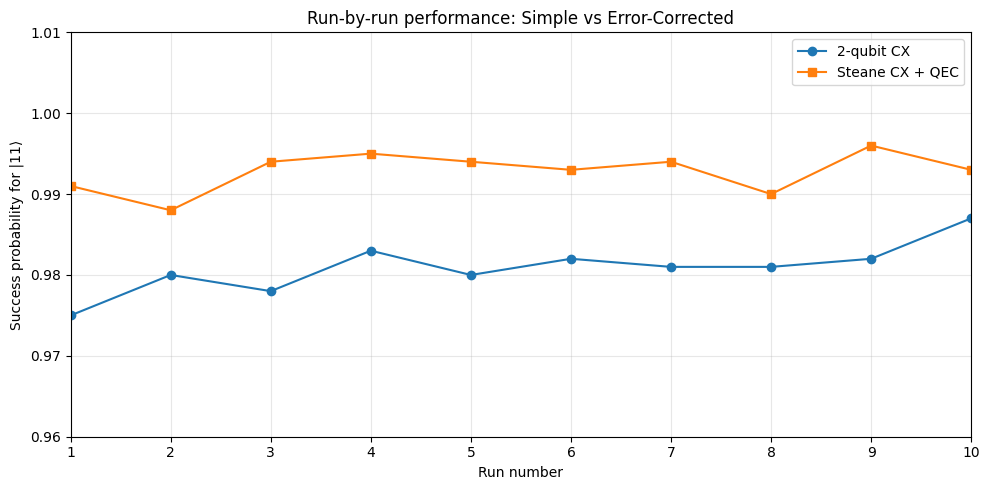

In [32]:
plot_qec_by_run(
    success_counts_without_ec,
    success_counts_with_ec,
    y_min=0.96,
    y_max=1.01,
)

Nice! Now we have some empirical evidence that QEC can beat no QEC when we use 1000 shots, at least at this noise level...

## Visualization B — When Does Error Correction Actually Help?

In the second experiment, we gradually increase the noise strength applied to every 2-qubit gate and track:

- The success probability of the **2-qubit physical circuit**
- The success probability of the **14-qubit error-corrected circuit**

As the noise increases, we look for a **crossover point** — a regime where:

- At low noise, the 2-qubit circuit performs better (less overhead, fewer opportunities for error)
- At higher noise, the error-corrected circuit starts to outperform it

This is a key concept in quantum error correction theory:
there is a **noise threshold** below which encoding is a disadvantage, and above which it becomes a necessity.

In [33]:
bit_flit_probabilities = np.arange(0.00, 0.201, 0.01)
shot_count = 1000

success_counts_without_ec_with_custom_noise = np.zeros(
    len(bit_flit_probabilities), dtype=float
)
success_counts_with_ec_with_custom_noise = np.zeros(
    len(bit_flit_probabilities), dtype=float
)

emulator_2q = StackMemorySimulator(min_qubits=2)
emulator_14q = StackMemorySimulator(min_qubits=14)

for index, p in enumerate(bit_flit_probabilities):
    custom_noise_model = BitFlipOn2QGateNoiseModel(p=p)
    transversal_cx_with_custom_noise = transform_circuit(
        transversal_cx, model=custom_noise_model
    )
    loaded_transversal_cx_with_custom_noise = load_circuit(
        transversal_cx_with_custom_noise,
        register_as_argument=True,
        kernel_name="transversal_cx_with_custom_noise",
    )

    @squin.kernel
    def steane_cx_with_custom_noise_experiment():
        qreg = steane_encode_two_logical()
        code1 = qreg[0:7]
        code2 = qreg[7:14]
        squin.broadcast.x(code1)
        loaded_transversal_cx_with_custom_noise(qreg)
        steane_error_correction_round(code1)
        steane_error_correction_round(code2)

        result1 = measure_in_logical_z_basis(code1)
        result2 = measure_in_logical_z_basis(code2)
        return result1, result2

    simple_cx_with_custom_noise = transform_circuit(simple_cx, model=custom_noise_model)
    loaded_simple_cx_with_custom_noise = load_circuit(
        simple_cx_with_custom_noise,
        register_as_argument=True,
        kernel_name="simple_cx_with_custom_noise",
    )

    @squin.kernel
    def cx_with_custom_noise_experiment():
        qubits = squin.qalloc(2)
        squin.x(qubits[0])

        loaded_simple_cx_with_custom_noise(qubits)

        result1 = squin.qubit.measure(qubits[0])
        result2 = squin.qubit.measure(qubits[1])

        return result1, result2

    task_without_ec_with_custom_noise = emulator_2q.task(
        cx_with_custom_noise_experiment
    )
    results_without_ec_with_custom_noise = task_without_ec_with_custom_noise.batch_run(
        shots=shot_count
    )
    success_counts_without_ec_with_custom_noise[index] = (
        results_without_ec_with_custom_noise[(1, 1)]
    )

    task_with_ec_with_custom_noise = emulator_14q.task(
        steane_cx_with_custom_noise_experiment
    )
    results_with_ec_with_custom_noise = task_with_ec_with_custom_noise.batch_run(
        shots=shot_count
    )
    success_counts_with_ec_with_custom_noise[index] = results_with_ec_with_custom_noise[
        (1, 1)
    ]

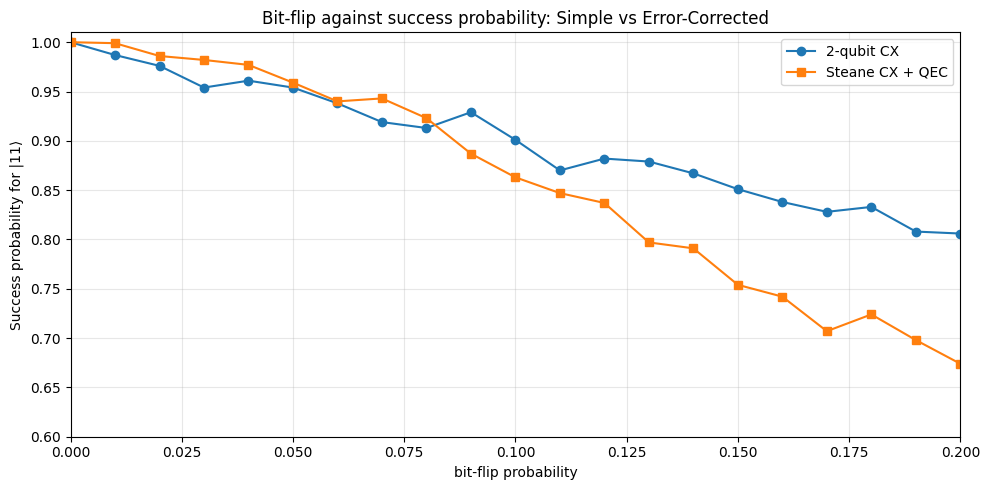

In [34]:
plot_qec_by_noise(
    simple_11=success_counts_without_ec_with_custom_noise,
    steane_11=success_counts_with_ec_with_custom_noise,
    p_range=bit_flit_probabilities,
    y_min=0.6,
    y_max=1.01,
)

### Reflection 4 🧠

Based on your plot, approximately where does the **crossover threshold** appear — the point at which the logical (error-corrected) circuit begins to outperform the physical 2-qubit circuit?

Now consider the noise model itself:

- How do you think this threshold would shift if the noise affected **all gates** in the circuit, not only the two-qubit CX gates?
- Would the advantage of encoding disappear, or simply move to a higher noise regime?

Finally, think about scaling the code:

- Could this limitation be mitigated by moving to color codes with **larger distance** (for example, $d = 5$ or $d = 7$)?
- Or would the increased number of qubits and gates only introduce **more opportunities for error** at today’s noise levels?

# 5. Wrap-Up: What We Learned, and Where to Go Next 🚀

Over the course of this notebook, we stepped from **physical qubits to logical qubits** and explored, in a hands-on way, what quantum error correction can and cannot do today.

In particular, you learned how to:

- Simulate a **noisy two-qubit CX gate** and observe how errors corrupt the expected $|11\rangle$ outcome
- Encode information using the **Steane $[[7,1,3]]$ color code**
- Build a **transversal logical CX** using 14 physical qubits
- Perform a (partial) **error-correction round** using syndrome measurements
- Compare the performance of a **physical CX** and a **logical, error-corrected CX**
- Identify that **error correction is not always better** — it depends on the noise regime

Perhaps most importantly, you saw that error correction is both **powerful and subtle**:
while it can suppress certain types of errors, it also introduces overhead, extra gates, and new pathways for noise to enter the system. As a result, there exists a practical “crossover” region: below some noise threshold, *encoding hurts*, and above it, *encoding helps*.

This is exactly the kind of behavior that current experimental platforms are working to push in the right direction.

---

## Next Steps and Further Reading 📖

This notebook is the first in a broader learning path inspired by **cutting-edge neutral-atom experiments** and modern fault-tolerance research.

In the next parts of this series, we will explore:

2. **Magic state distillation**
   How non-Clifford states can be purified and used to unlock universal quantum computation.

3. **Improving error correction strategies**
   Techniques such as **flag qubits** and **correlated decoding**, which help detect dangerous error patterns more efficiently.

To connect these ideas with ongoing research, you may want to explore the following papers:

### Key QuEra and Neutral-Atom References

- Bluvstein *et al.* (2024):
  *Logical quantum processor based on reconfigurable atom arrays*
  https://www.nature.com/articles/s41586-023-06927-3

- Rodriguez *et al.* (2025):
  *Experimental demonstration of logical magic state distillation*
  https://www.nature.com/articles/s41586-025-09367-3

These works demonstrate how **distance-3 color codes** and **transversal logical operations** can be realized on reconfigurable neutral-atom hardware.

### Beyond Neutral Atoms

It is important to recognize that this approach is not unique to neutral atoms. Other platforms are exploring related ideas as well:

- Quantinuum (2023):
  *Implementing Fault-Tolerant Entangling Gates on the Five-Qubit Code and the Color Code*
  https://arxiv.org/abs/2309.14280

This paper investigates **logical CX gates** implemented through error correction in ion-based architectures, highlighting how similar principles can apply across very different physical systems.

### More Codes: Error Correction Zoo 🐾

To dive deeper into the wide world of error-correcting codes, explore the **Error Correction Zoo**:

https://errorcorrectionzoo.org
